## Geoploitical Conflict Forecasting Using [ACLED](https://acleddata.com/curated-data-files/) Data and Auto ARIMA model.

---



## **Project Objective**
This projest's core objective is to develop a predictive model for forecasting the occurrence of conflicts across various regions in the world over a decade-long timeframe. This project aims to assist decision-makers in de-escalating tensions and mitigating the aftermath of political conflicts.

In [ ]:
# Install required packages
!pip install pmdarima statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
!cat /proc/cpuinfo | grep 'model name' | uniq  # CPU info since we utilizing cpu for thiss project
!nvidia-smi

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import psutil
print(f"Total RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")


Total RAM: 13.61 GB


In [ ]:
# Data manipulation and visualization
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical computing
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For advanced statistical graphics

# Time series analysis
from pmdarima import auto_arima  # For automated ARIMA model selection
from statsmodels.tsa.stattools import adfuller, kpss  # For stationarity tests
from statsmodels.tsa.seasonal import seasonal_decompose  # For time series decomposition

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Machine learning
from sklearn.preprocessing import LabelEncoder  # For encoding categorical variables
from sklearn.cluster import KMeans  # For K-Means clustering
from sklearn.metrics import mean_squared_error  # For calculating mean squared error

# Statistical functions
from scipy import stats  # For statistical functions and distributions

import os  # For interacting with the operating system
import warnings  # For controlling warnings
warnings.filterwarnings("ignore")

*Using Google Colab*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dir name 'ACLED' has the data to work with, cd to 'ACLED'

%cd /content/drive/My Drive/ACLED

/content/drive/My Drive/ACLED


In [ ]:
# list the items in this dir /content/drive/My Drive/ACLED

!ls /content/drive/My\ Drive/ACLED

Africa_1997-2024_Oct04.csv		 LatinAmerica_2018-2024_Oct04.csv
Asia-Pacific_2018-2024_Oct04.csv	 MiddleEast_2015-2024_Oct04.csv
Europe-Central-Asia_2018-2024_Oct04.csv  USA_Canada_2020_2024_Oct04.csv


In [ ]:
# List of CSV files from our ACLED folder dir
csv_files = ['Africa_1997-2024_Oct04.csv', 'LatinAmerica_2018-2024_Oct04.csv',
             'Asia-Pacific_2018-2024_Oct04.csv', 'MiddleEast_2015-2024_Oct04.csv',
             'Europe-Central-Asia_2018-2024_Oct04.csv', 'USA_Canada_2020_2024_Oct04.csv']

*Using Kaggle Notebook*

In [ ]:
# Input data files are available in the read-only "../input/" directory
"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""


"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [ ]:
# Define the paths to the CSV files
"""csv_files = [
    "/kaggle/input/acled-conflict-data-oct-2024/Europe-Central-Asia_2018-2024_Oct04.csv",
"/kaggle/input/acled-conflict-data-oct-2024/MiddleEast_2015-2024_Oct04.csv",
"/kaggle/input/acled-conflict-data-oct-2024/Asia-Pacific_2018-2024_Oct04.csv",
"/kaggle/input/acled-conflict-data-oct-2024/USA_Canada_2020_2024_Oct04.csv",
"/kaggle/input/acled-conflict-data-oct-2024/Africa_1997-2024_Oct04.csv",
"/kaggle/input/acled-conflict-data-oct-2024/LatinAmerica_2018-2024_Oct04.csv"
]"""

'csv_files = [\n    "/kaggle/input/acled-conflict-data-oct-2024/Europe-Central-Asia_2018-2024_Oct04.csv",\n"/kaggle/input/acled-conflict-data-oct-2024/MiddleEast_2015-2024_Oct04.csv",\n"/kaggle/input/acled-conflict-data-oct-2024/Asia-Pacific_2018-2024_Oct04.csv",\n"/kaggle/input/acled-conflict-data-oct-2024/USA_Canada_2020_2024_Oct04.csv",\n"/kaggle/input/acled-conflict-data-oct-2024/Africa_1997-2024_Oct04.csv",\n"/kaggle/input/acled-conflict-data-oct-2024/LatinAmerica_2018-2024_Oct04.csv"\n]'

In [ ]:
# Reading the CSV files into named DataFrames ( works for both kaggle and colab at this point)

USA_Canada = pd.read_csv(csv_files[0])
Africa = pd.read_csv(csv_files[1])
LatinAmerica = pd.read_csv(csv_files[2])
MiddleEast = pd.read_csv(csv_files[3])
Asia = pd.read_csv(csv_files[4])
Europe = pd.read_csv(csv_files[5])

print("Our 6 datasets are ready to read now.")

Our 6 datasets are ready to read now.


In [ ]:
# To keep track of which data comes from which region, we considered adding a new column indicating the region for each row.
Africa['Region'] = 'Africa'
Asia['Region'] = 'Asia'
Europe['Region'] = 'Europe'
LatinAmerica['Region'] = 'Latin America'
MiddleEast['Region'] = 'Middle East'
USA_Canada['Region'] = 'USA/Canada'

In [ ]:
USA_Canada.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388401 entries, 0 to 388400
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       388401 non-null  object 
 1   event_date          388401 non-null  object 
 2   year                388401 non-null  int64  
 3   time_precision      388401 non-null  int64  
 4   disorder_type       388401 non-null  object 
 5   event_type          388401 non-null  object 
 6   sub_event_type      388401 non-null  object 
 7   actor1              388401 non-null  object 
 8   assoc_actor_1       105320 non-null  object 
 9   inter1              388401 non-null  object 
 10  actor2              282484 non-null  object 
 11  assoc_actor_2       77312 non-null   object 
 12  inter2              282484 non-null  object 
 13  interaction         388401 non-null  object 
 14  civilian_targeting  115195 non-null  object 
 15  iso                 388401 non-nul

In [ ]:
Africa.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337508 entries, 0 to 337507
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       337508 non-null  object 
 1   event_date          337508 non-null  object 
 2   year                337508 non-null  int64  
 3   time_precision      337508 non-null  int64  
 4   disorder_type       337508 non-null  object 
 5   event_type          337508 non-null  object 
 6   sub_event_type      337508 non-null  object 
 7   actor1              337508 non-null  object 
 8   assoc_actor_1       117233 non-null  object 
 9   inter1              337508 non-null  object 
 10  actor2              179511 non-null  object 
 11  assoc_actor_2       40064 non-null   object 
 12  inter2              179511 non-null  object 
 13  interaction         337508 non-null  object 
 14  civilian_targeting  96454 non-null   object 
 15  iso                 337508 non-nul

In [ ]:
LatinAmerica.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583401 entries, 0 to 583400
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       583401 non-null  object 
 1   event_date          583401 non-null  object 
 2   year                583401 non-null  int64  
 3   time_precision      583401 non-null  int64  
 4   disorder_type       583401 non-null  object 
 5   event_type          583401 non-null  object 
 6   sub_event_type      583401 non-null  object 
 7   actor1              583401 non-null  object 
 8   assoc_actor_1       306074 non-null  object 
 9   inter1              583401 non-null  object 
 10  actor2              235482 non-null  object 
 11  assoc_actor_2       74302 non-null   object 
 12  inter2              235482 non-null  object 
 13  interaction         583401 non-null  object 
 14  civilian_targeting  65929 non-null   object 
 15  iso                 583401 non-nul

In [ ]:
MiddleEast.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467218 entries, 0 to 467217
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       467218 non-null  object 
 1   event_date          467218 non-null  object 
 2   year                467218 non-null  int64  
 3   time_precision      467218 non-null  int64  
 4   disorder_type       467218 non-null  object 
 5   event_type          467218 non-null  object 
 6   sub_event_type      467218 non-null  object 
 7   actor1              467218 non-null  object 
 8   assoc_actor_1       136353 non-null  object 
 9   inter1              467218 non-null  object 
 10  actor2              261259 non-null  object 
 11  assoc_actor_2       53143 non-null   object 
 12  inter2              261260 non-null  object 
 13  interaction         467218 non-null  object 
 14  civilian_targeting  64591 non-null   object 
 15  iso                 467218 non-nul

In [ ]:
Asia.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426484 entries, 0 to 426483
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       426484 non-null  object 
 1   event_date          426484 non-null  object 
 2   year                426484 non-null  int64  
 3   time_precision      426484 non-null  int64  
 4   disorder_type       426484 non-null  object 
 5   event_type          426484 non-null  object 
 6   sub_event_type      426484 non-null  object 
 7   actor1              426484 non-null  object 
 8   assoc_actor_1       157733 non-null  object 
 9   inter1              426484 non-null  object 
 10  actor2              148736 non-null  object 
 11  assoc_actor_2       27206 non-null   object 
 12  inter2              148736 non-null  object 
 13  interaction         426484 non-null  object 
 14  civilian_targeting  14578 non-null   object 
 15  iso                 426484 non-nul

In [ ]:
Europe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79654 entries, 0 to 79653
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id_cnty       79654 non-null  object 
 1   event_date          79654 non-null  object 
 2   year                79654 non-null  int64  
 3   time_precision      79654 non-null  int64  
 4   disorder_type       79654 non-null  object 
 5   event_type          79654 non-null  object 
 6   sub_event_type      79654 non-null  object 
 7   actor1              79654 non-null  object 
 8   assoc_actor_1       58962 non-null  object 
 9   inter1              79654 non-null  object 
 10  actor2              7836 non-null   object 
 11  assoc_actor_2       3240 non-null   object 
 12  inter2              7836 non-null   object 
 13  interaction         79654 non-null  object 
 14  civilian_targeting  830 non-null    object 
 15  iso                 79654 non-null  int64  
 16  regi

In [ ]:
# Concatenate all DataFrames into a single DataFrame
df_all = pd.concat([USA_Canada, Africa, LatinAmerica, MiddleEast, Asia, Europe], ignore_index=True)
df_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282666 entries, 0 to 2282665
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   event_id_cnty       object 
 1   event_date          object 
 2   year                int64  
 3   time_precision      int64  
 4   disorder_type       object 
 5   event_type          object 
 6   sub_event_type      object 
 7   actor1              object 
 8   assoc_actor_1       object 
 9   inter1              object 
 10  actor2              object 
 11  assoc_actor_2       object 
 12  inter2              object 
 13  interaction         object 
 14  civilian_targeting  object 
 15  iso                 int64  
 16  region              object 
 17  country             object 
 18  admin1              object 
 19  admin2              object 
 20  admin3              object 
 21  location            object 
 22  latitude            float64
 23  longitude           float64
 24  geo_precision       int6

In [ ]:
# info on df_all
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282666 entries, 0 to 2282665
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   event_id_cnty       object 
 1   event_date          object 
 2   year                int64  
 3   time_precision      int64  
 4   disorder_type       object 
 5   event_type          object 
 6   sub_event_type      object 
 7   actor1              object 
 8   assoc_actor_1       object 
 9   inter1              object 
 10  actor2              object 
 11  assoc_actor_2       object 
 12  inter2              object 
 13  interaction         object 
 14  civilian_targeting  object 
 15  iso                 int64  
 16  region              object 
 17  country             object 
 18  admin1              object 
 19  admin2              object 
 20  admin3              object 
 21  location            object 
 22  latitude            float64
 23  longitude           float64
 24  geo_precision       int6

In [ ]:
# previewing first 5 observations of our concat. dfs
df_all.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,Region
0,BFO12659,2024-10-04,2024,1,Political violence,Explosions/Remote violence,Air/drone strike,Military Forces of Burkina Faso (2022-),NaN,State forces,...,10.0116,-4.0287,2,Undisclosed Source,Local partner-Other,"On 4 October 2024, the Burkinabe force carried...",5,NaN,1728335020,USA/Canada
1,BFO12661,2024-10-04,2024,1,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,14.0875,-1.6418,2,Al Zallaqa; Whatsapp,New media,"On 4 October 2024, JNIM militants carried out ...",0,NaN,1728335020,USA/Canada
2,BFO12665,2024-10-04,2024,1,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,13.6758,-2.3336,1,Whatsapp,New media,"On 4 October 2024, JNIM militants attacked a p...",0,NaN,1728335020,USA/Canada
3,BFO12682,2024-10-04,2024,1,Strategic developments,Strategic developments,Other,JNIM: Group for Support of Islam and Muslims,NaN,Rebel group,...,12.7097,-0.1311,2,Undisclosed Source,Local partner-Other,"Non-violent activity: On 4 October 2024, JNIM ...",0,NaN,1728335020,USA/Canada
4,BFO12687,2024-10-04,2024,1,Demonstrations,Riots,Violent demonstration,Rioters (Burkina Faso),Students (Burkina Faso),Rioters,...,12.4634,-3.4608,1,Facebook,New media,"On 4 October 2024, students from the modern li...",0,crowd size=no report,1728335020,USA/Canada


In [ ]:
# displaying the value counts of our new, Region col
df_all.Region.value_counts()

,count
Region,
Latin America,583401
Middle East,467218
Asia,426484
USA/Canada,388401
Africa,337508
Europe,79654


In [ ]:
# let's inspect our df_all columns
df_all.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp', 'Region'],
      dtype='object')

In [ ]:
# saving a copy of our df
df = df_all.copy()

### **Data Cleaning.**

In [ ]:
# Check for duplicates
duplicates = df_all.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df_all[duplicates])


Number of duplicate rows: 0


In [ ]:
# Check for missing data
missing_data = df_all.isnull().sum()
print("\nMissing data per column:")
print(missing_data)


Missing data per column:
event_id_cnty               0
event_date                  0
year                        0
time_precision              0
disorder_type               0
event_type                  0
sub_event_type              0
actor1                      0
assoc_actor_1         1400991
inter1                      0
actor2                1167358
assoc_actor_2         2007399
inter2                1167357
interaction                 0
civilian_targeting    1925089
iso                         0
region                      0
country                     0
admin1                    727
admin2                  65305
admin3                1159450
location                    0
latitude                    0
longitude                   0
geo_precision               0
source                      0
source_scale                0
notes                       0
fatalities                  0
tags                  1323797
timestamp                   0
Region                      0
dtype: int64


In [ ]:
# Analyze the missing data further
missing_percentage = (df_all.isnull().sum() / len(df)) * 100
print("\nMissing data percentage per column:")
missing_percentage


Missing data percentage per column:


,0
event_id_cnty,0.000000
event_date,0.000000
year,0.000000
time_precision,0.000000
disorder_type,0.000000
event_type,0.000000
sub_event_type,0.000000
actor1,0.000000
assoc_actor_1,61.375208
inter1,0.000000


In [ ]:
# Drop columns with more than 1000 missing values
threshold = 1000
df = df.dropna(thresh=len(df) - threshold, axis=1)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282666 entries, 0 to 2282665
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   event_id_cnty       object 
 1   event_date          object 
 2   year                int64  
 3   time_precision      int64  
 4   disorder_type       object 
 5   event_type          object 
 6   sub_event_type      object 
 7   actor1              object 
 8   assoc_actor_1       object 
 9   inter1              object 
 10  actor2              object 
 11  assoc_actor_2       object 
 12  inter2              object 
 13  interaction         object 
 14  civilian_targeting  object 
 15  iso                 int64  
 16  region              object 
 17  country             object 
 18  admin1              object 
 19  admin2              object 
 20  admin3              object 
 21  location            object 
 22  latitude            float64
 23  longitude           float64
 24  geo_precision       int6

### **Trend of Conflicts Over The years**

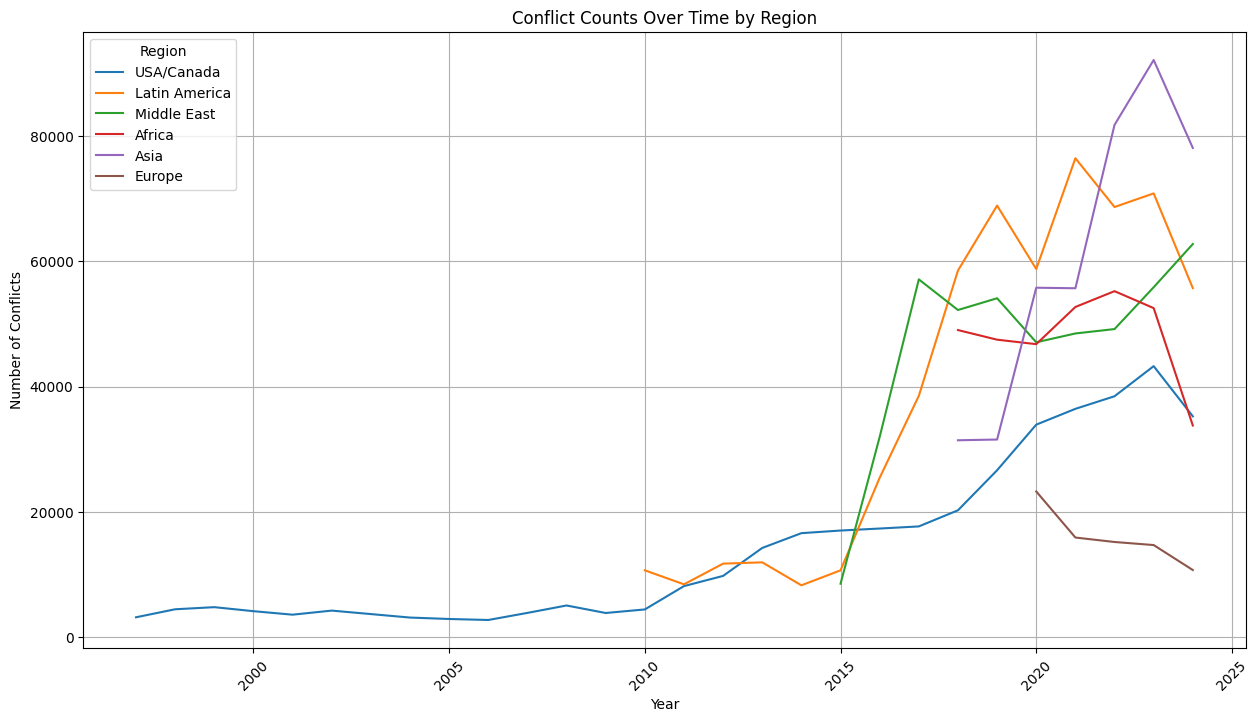

In [ ]:
# plotting the trend of conflict over the years across all regions

# Group data by year and region, count conflicts
c_counts = df_all.groupby(['year', 'Region'])['event_id_cnty'].count().reset_index()

# Plotting
plt.figure(figsize=(15, 8))
sns.lineplot(x='year', y='event_id_cnty', hue='Region', data=c_counts)
plt.title('Conflict Counts Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Number of Conflicts')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



### **Data Preprocessing**

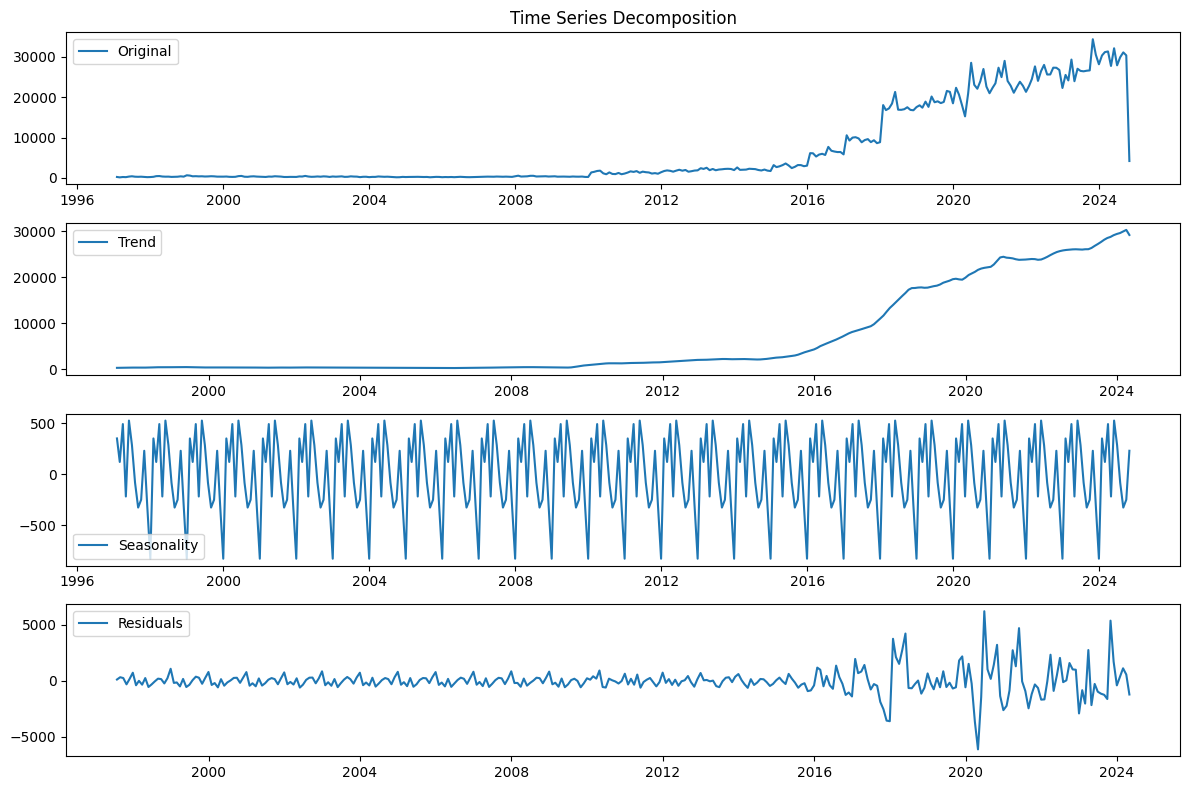

In [ ]:
#check the seasonality of df_all
df_all = df_all.reset_index()  # Reset index to make 'event_id' a columns again

# Convert 'event_date' to datetime objects if it's not already
df_all['event_date'] = pd.to_datetime(df_all['event_date'])

# Set 'event_date' as the index
df_all = df_all.set_index('event_date')

# Resample the data to a suitable frequency (e.g., monthly)
# and count the number of events in each period
monthly_counts = df_all['event_id_cnty'].resample('M').count()

# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)  # Adjust period if needed

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(monthly_counts, label='Original')
plt.legend(loc='best')
plt.title('Time Series Decomposition')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
# Reset the index to bring 'event_date' back as a column
df_all = df_all.reset_index()

# Dataframe is already loaded into `df`
df['event_date'] = pd.to_datetime(df['event_date'])  # Convert 'event_date' to datetime

In [ ]:
# Aggregate data by 'event_date' and 'Region' to count conflict occurrences
agg_data = df.groupby(['event_date', 'year', 'Region'])['event_id_cnty'].count().reset_index()
agg_data.rename(columns={'event_id_cnty': 'conflict_count'}, inplace=True)

# Display the aggregated data
agg_data.head()


,event_date,year,Region,conflict_count
0,1997-01-01,1997,USA/Canada,18
1,1997-01-02,1997,USA/Canada,3
2,1997-01-03,1997,USA/Canada,6
3,1997-01-04,1997,USA/Canada,4
4,1997-01-05,1997,USA/Canada,8


In [ ]:
#value counts of Regions our aggregated data
agg_data.Region.value_counts()

,count
Region,
USA/Canada,10128
Latin America,5391
Middle East,3565
Africa,2469
Asia,2469
Europe,1739


In [ ]:
# Train-validation-test split (70%, 15%, 15%)
train_size = int(len(agg_data) * 0.7)
val_size = int(len(agg_data) * 0.15)
test_size = len(agg_data) - train_size - val_size

train = agg_data[:train_size]
val = agg_data[train_size:train_size + val_size]
test = agg_data[train_size + val_size:]

# Display the sizes of the split data
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

Training set size: 18032
Validation set size: 3864
Test set size: 3865


In [ ]:
print(train.index)
print(train.head())

RangeIndex(start=0, stop=18032, step=1)
  event_date  year      Region  conflict_count
0 1997-01-01  1997  USA/Canada              18
1 1997-01-02  1997  USA/Canada               3
2 1997-01-03  1997  USA/Canada               6
3 1997-01-04  1997  USA/Canada               4
4 1997-01-05  1997  USA/Canada               8


### Stationary Checks - ADF test and differencing if necessary

This cell block;s function iterates through each unique region in the agg_data df.
Stationarity is crucial for reliable time series analysis. The ADF test helps determine if a time series meets this crucial assumption.Non-stationary data is sure lead to inaccurate forecasts and unreliable model results, when that happens, we a apply differencing to make the data stationary, hence improving the results of our prediction and model performance.


In [ ]:

def check_stationarity(series):
    """
    Perform ADF test and return stationarity status and p-value
    """
    try:
        result = adfuller(series.dropna())
        return result[1] < 0.05, result[1]
    except:
        return False, None

def difference_series(series, regular_order=1, seasonal_order=0, seasonal_period=12):
    """
    Applying both regular and seasonal differencing to a time series.

    Parameters:
    -----------
    series : pd.Series
        Original time series
    regular_order : int
        Number of regular differences to apply
    seasonal_order : int
        Number of seasonal differences to apply
    seasonal_period : int
        Period for seasonal differencing (12 per our seaonal decmposition plots)
    """
    diff_series = series.copy()

    # Apply seasonal differencing first
    for _ in range(seasonal_order):
        diff_series = diff_series.diff(seasonal_period)

    # Then apply regular differencing
    for _ in range(regular_order):
        diff_series = diff_series.diff(1)

    return diff_series.dropna()

def find_optimal_differencing(series, max_regular_diff=2, max_seasonal_diff=1, seasonal_period=12):
    """
    Find optimal regular and seasonal differencing orders
    """
    best_regular_order = 0
    best_seasonal_order = 0
    original_series = series.copy()

    # Try seasonal differencing first
    for s in range(max_seasonal_diff + 1):
        if s > 0:
            series = difference_series(original_series, 0, s, seasonal_period)

        # Then try regular differencing
        for d in range(max_regular_diff + 1):
            if d > 0:
                test_series = difference_series(series, d, 0)
            else:
                test_series = series

            is_stationary, p_value = check_stationarity(test_series)

            if is_stationary:
                return d, s, p_value

    return max_regular_diff, max_seasonal_diff, None

# Process each region
differencing_results = {}
for region in agg_data['Region'].unique():
    region_data = agg_data[agg_data['Region'] == region]
    series = region_data['conflict_count']

    print(f"\nProcessing Region: {region}")

    # Check initial stationarity
    is_stationary, p_value = check_stationarity(series)
    print(f"Initial stationarity test p-value: {p_value}")

    if is_stationary:
        print("Series is already stationary")
        differencing_results[region] = (0, 0, p_value)
        continue

    # Find optimal differencing orders
    regular_order, seasonal_order, final_p_value = find_optimal_differencing(
        series,
        max_regular_diff=2,
        max_seasonal_diff=1,
        seasonal_period=12
    )

    print(f"Optimal regular differencing order: {regular_order}")
    print(f"Optimal seasonal differencing order: {seasonal_order}")
    print(f"Final p-value after differencing: {final_p_value}")

    # Store results
    differencing_results[region] = (regular_order, seasonal_order, final_p_value)

    # Create differenced series for later use
    differenced_series = difference_series(
        series,
        regular_order=regular_order,
        seasonal_order=seasonal_order,
        seasonal_period=12
    )



Processing Region: USA/Canada
Initial stationarity test p-value: 0.8197812414228279
Optimal regular differencing order: 1
Optimal seasonal differencing order: 0
Final p-value after differencing: 0.0

Processing Region: Latin America
Initial stationarity test p-value: 0.4422576912917452
Optimal regular differencing order: 1
Optimal seasonal differencing order: 0
Final p-value after differencing: 0.0

Processing Region: Middle East
Initial stationarity test p-value: 0.09588555170535706
Optimal regular differencing order: 1
Optimal seasonal differencing order: 0
Final p-value after differencing: 2.4079996589884623e-27

Processing Region: Africa
Initial stationarity test p-value: 3.0596213077182294e-09
Series is already stationary

Processing Region: Asia
Initial stationarity test p-value: 0.2077360540887646
Optimal regular differencing order: 1
Optimal seasonal differencing order: 0
Final p-value after differencing: 1.1549999215027863e-20

Processing Region: Europe
Initial stationarity t

In [ ]:
    # You can store the differenced series if needed
    # region_data['differenced_conflict_count'] = differenced_series

print("\nSummary of differencing orders:")
    for region, (d, D, p_value) in differencing_results.items():
        print(f"{region}: d={d}, D={D}, final p-value={p_value}")




Summary of differencing orders:
USA/Canada: d=1, D=0, final p-value=0.0
Latin America: d=1, D=0, final p-value=0.0
Middle East: d=1, D=0, final p-value=2.4079996589884623e-27
Africa: d=0, D=0, final p-value=3.0596213077182294e-09
Asia: d=1, D=0, final p-value=1.1549999215027863e-20
Europe: d=0, D=0, final p-value=4.384030246871838e-07


Observations:

Differencing Orders (d, D):

Most regions require first-order differencing (d=1) to achieve stationarity.
Only Africa and Europe appear to be stationary in their original form (d=0).
No regions require seasonal differencing (D=0).


Final p-values:

All p-values are extremely small, indicating strong evidence against the null hypothesis of no autocorrelation. This suggests that differencing has effectively removed autocorrelation in the time series data for each region.

In [ ]:


def prepare_data_for_forecasting(agg_data, region=None):
    """
    Prepare time series data for forecasting.
    """
    # Filter by region if specified
    if region:
        data = agg_data[agg_data['Region'] == region].copy()
    else:
        data = agg_data.copy()

    # Ensure event_date is datetime
    data['event_date'] = pd.to_datetime(data['event_date'])

    # Set event_date as index and sort
    data.set_index('event_date', inplace=True)
    data.sort_index(inplace=True)

    # Resample to monthly frequency and fill gaps
    monthly_data = data['conflict_count'].resample('M').sum()
    monthly_data = monthly_data.fillna(0)

    return monthly_data

## **Fit Model with Hyperparameter Tuning (Auto ARIMA)**

In [ ]:
def train_arima_model(data, seasonal=True):
    """
    Train Auto ARIMA model with optimal parameters.
    """
    model = auto_arima(
        data,
        seasonal=seasonal,
        m=12,  # Monthly seasonality
        d=1,   # First difference
        D=1,   # First seasonal difference
        start_p=0, max_p=2,
        start_q=0, max_q=2,
        start_P=0, max_P=1,
        start_Q=0, max_Q=1,
        stepwise=True,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )
    return model

In [ ]:
# Display the summary of the best model
data = prepare_data_for_forecasting(agg_data)
model = train_arima_model(data)
#print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5935.681, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5835.771, Time=1.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5813.330, Time=1.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5924.819, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5805.310, Time=2.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5834.414, Time=0.81 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5808.973, Time=1.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5796.598, Time=2.35 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5808.988, Time=2.96 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5824.447, Time=3.71 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5912.592, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5810.039, Time=1.58 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=5788.150, Time=4.11 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5807.008, Time=2.96 sec
 ARIMA(2,1,1)(1,1,0

## Evaluate Model Performance

In [ ]:
def evaluate_model_performance(model, train_data, test_data):
    """
    Evaluate model performance using various metrics.
    """
    # Generate in-sample predictions
    in_sample_predictions = model.predict_in_sample()

    # Generate out-of-sample predictions for test data
    n_periods = len(test_data)
    forecasts = model.predict(n_periods=n_periods)

    # Calculate metrics
    metrics = {
        'Training Set Metrics': {
            'RMSE': np.sqrt(mean_squared_error(train_data, in_sample_predictions)),
            'MAE': mean_absolute_error(train_data, in_sample_predictions),
            'R-squared': r2_score(train_data, in_sample_predictions),
            'MAPE': np.mean(np.abs((train_data - in_sample_predictions) / train_data)) * 100
        },
        'Test Set Metrics': {
            'RMSE': np.sqrt(mean_squared_error(test_data, forecasts)),
            'MAE': mean_absolute_error(test_data, forecasts),
            'R-squared': r2_score(test_data, forecasts),
            'MAPE': np.mean(np.abs((test_data - forecasts) / test_data)) * 100
        }
    }

    return metrics

## Residual Analysis

In [ ]:
 # Import statsmodels here
import statsmodels.api as sm

In [ ]:
def plot_residuals_analysis(model, data):
    """
    Perform and plot residuals analysis with fewer plots.
    """
    # Get residuals
    in_sample_predictions = model.predict_in_sample()
    residuals = data - in_sample_predictions

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid of plots

    # Residuals over time
    axes[0, 0].plot(residuals.index, residuals, 'o-', markersize=2)
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residual')
    axes[0, 0].grid(True)

    # Distribution
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Residuals Distribution')
    axes[0, 1].set_xlabel('Residual')

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')

    # Residuals vs Fitted
    axes[1, 1].scatter(in_sample_predictions, residuals, alpha=0.5)
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_title('Residuals vs Fitted Values')
    axes[1, 1].set_xlabel('Fitted Values')
    axes[1, 1].set_ylabel('Residuals')

    plt.tight_layout()
    return fig

In [ ]:
def plot_residuals_analysis(model, data):
    """
    Perform and plot residuals analysis.
    """
    # Get residuals
    in_sample_predictions = model.predict_in_sample()
    residuals = data - in_sample_predictions

    fig = plt.figure(figsize=(14, 11))

    # Residuals over time
    plt.subplot(321)
    plt.plot(residuals.index, residuals, 'o-', markersize=2)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)

    # Distribution
    plt.subplot(322)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residual')

    # Q-Q plot
    plt.subplot(323)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    # Residuals vs Fitted
    plt.subplot(324)
    plt.scatter(in_sample_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # ACF
    plt.subplot(325)
    pd.plotting.autocorrelation_plot(residuals)
    plt.title('Autocorrelation of Residuals')

    # Stats
    plt.subplot(326)
    stats_text = (
        f'Residuals Statistics:\n'
        f'Mean: {residuals.mean():.2f}\n'
        f'Std Dev: {residuals.std():.2f}\n'
        f'Skewness: {stats.skew(residuals):.2f}\n'
        f'Kurtosis: {stats.kurtosis(residuals):.2f}\n'
        f'Jarque-Bera test p-value: {stats.jarque_bera(residuals)[1]:.4f}\n'
        f'Ljung-Box test p-value: {sm.stats.diagnostic.acorr_ljungbox(residuals, lags=[10])[1][0]:.4f}'


    )
    plt.text(0.1, 0.5, stats_text, fontsize=10, transform=plt.gca().transAxes)
    plt.axis('off')

    plt.tight_layout()
    return fig

## Functions to generate and plot year forecast

In [ ]:
def generate_forecast(model, n_periods=120):  # 120 months = 10 years
    """
    Generate forecasts with confidence intervals.
    """
    # Get forecast
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    # Create forecast dates
    last_date = model.predict_in_sample().index[-1]
    forecast_dates = pd.date_range(
        start=last_date + pd.offsets.MonthEnd(1),
        periods=n_periods,
        freq='M'
    )

    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'forecast': forecast,
        'lower_ci': conf_int[:, 0],
        'upper_ci': conf_int[:, 1]
    }, index=forecast_dates)

    return forecast_df

In [ ]:
def plot_forecast(historical_data, forecast_df, title="Conflict Forecast"):
    """
    Plot historical data and forecast with confidence intervals.
    """
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(historical_data.index, historical_data.values,
            label='Historical Data', color='blue')

    # Plot forecast
    plt.plot(forecast_df.index, forecast_df['forecast'],
            label='Forecast', color='red', linestyle='--')

    # Plot confidence intervals
    plt.fill_between(forecast_df.index,
                    forecast_df['lower_ci'],
                    forecast_df['upper_ci'],
                    color='red', alpha=0.2, label='95% Confidence Interval')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Conflict Count')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt

In [ ]:
def split_data(data, test_size=12):
    """
    Splits time series data into train and test sets.
    """
    train_data = data[:-test_size]
    test_data = data[-test_size:]
    return train_data, test_data

def forecast_conflicts(agg_data, region=None, test_size=12):
    """
    Main function to generate and visualize forecasts with evaluation.
    """
    print("1. Preparing data...")
    data = prepare_data_for_forecasting(agg_data, region)

    print("2. Splitting data into train and test sets...")
    train_data, test_data = split_data(data, test_size=test_size)

    print("3. Training ARIMA model...")
    model = train_arima_model(train_data)

    print("4. Evaluating model performance...")
    metrics = evaluate_model_performance(model, train_data, test_data)
    print("\nModel Evaluation Metrics:")
    print("-" * 50)
    for dataset, dataset_metrics in metrics.items():
        print(f"\n{dataset}:")
        for metric, value in dataset_metrics.items():
            print(f"{metric}: {value:.4f}")

    print("\n5. Analyzing residuals...")
    residuals_fig = plot_residuals_analysis(model, train_data)
    plt.show()

    print("\n6. Generating future forecast...")
    forecast_df = generate_forecast(model)

    print("\n7. Creating final forecast plot...")
    title = f"Conflict Forecast for {region if region else 'All Regions'}"
    plot = plot_forecast(data, forecast_df, title)
    plt.show()

    return model, forecast_df, metrics

## Forecasting for all Regions in our Data.

1. Preparing data...
2. Splitting data into train and test sets...
3. Training ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5435.769, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5334.845, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5295.721, Time=0.88 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5415.137, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5296.034, Time=1.56 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5329.920, Time=0.73 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5314.830, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5280.837, Time=1.41 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5389.808, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5280.344, Time=1.74 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5308.951, Time=1.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5304.716, Time=4.90 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=5281.057, Time=2

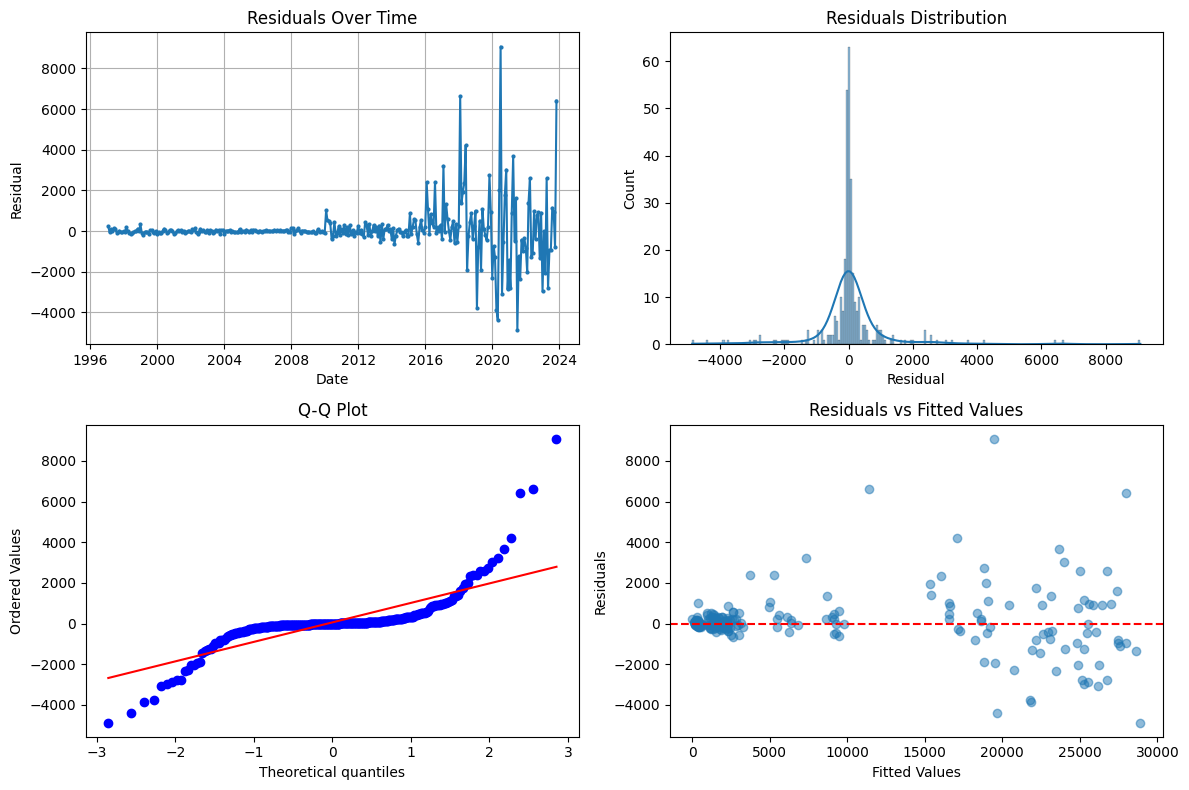


6. Generating future forecast...

7. Creating final forecast plot...


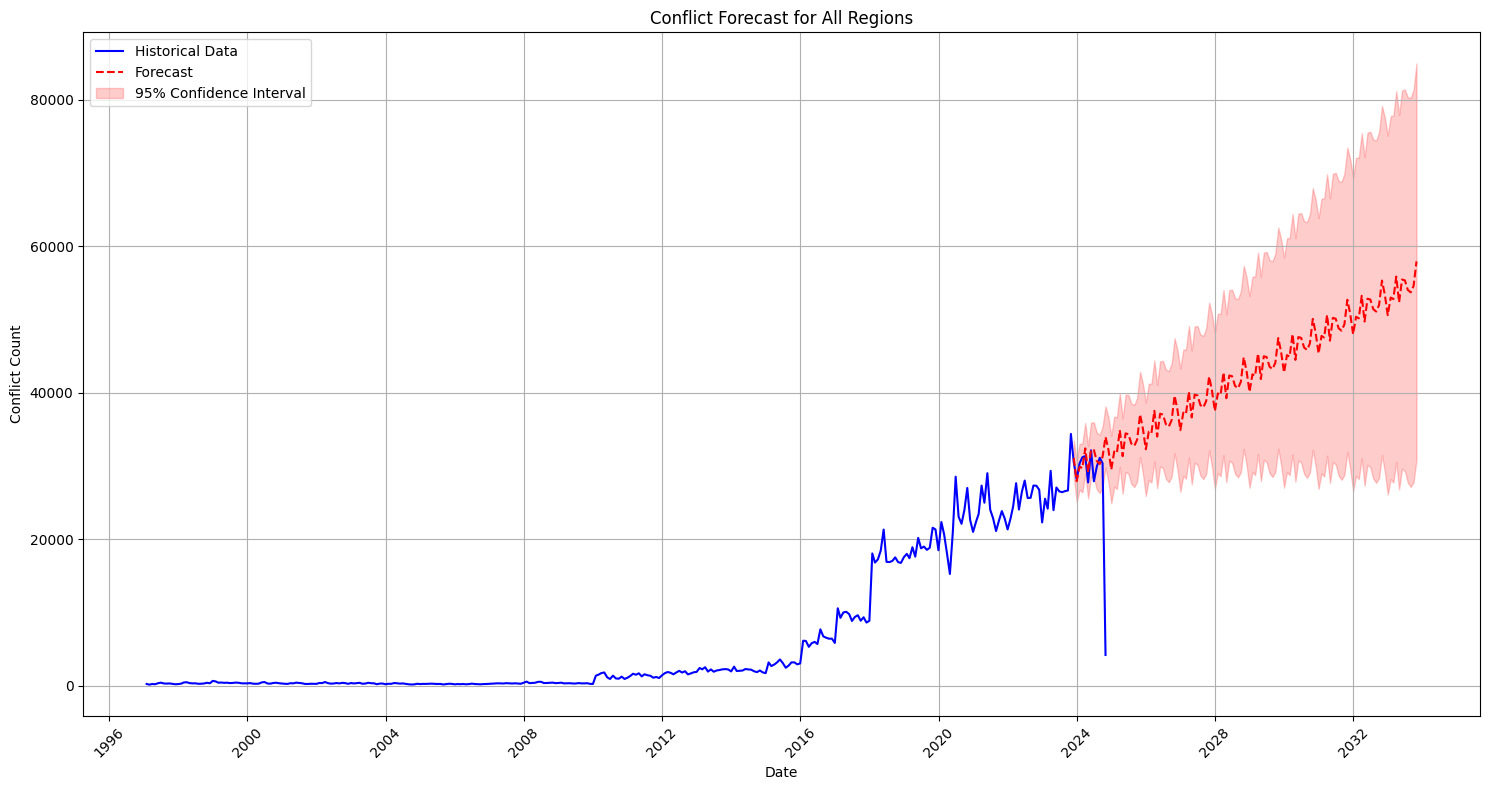

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For calculating mean squared error, mean absolute error and r2_score
# For all regions combined:
model, forecast_df, plot = forecast_conflicts(agg_data)
plt.show()

In [ ]:
# Display the summary of the best model - forecasting for all regions
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  322
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2635.172
Date:                            Sun, 12 Jan 2025   AIC                           5280.344
Time:                                    11:56:40   BIC                           5299.011
Sample:                                01-31-1997   HQIC                          5287.807
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4937      0.065      7.589      0.000       0.366       0.621
ma.L1         -0.8144      0.044   

Interpretation:

The SARIMAX(1, 1, 1)x(1, 1, 1, 12) model appears to be a reasonable fit for the data, based on the relatively low AIC, BIC, and HQIC values.
The coefficients for the autoregressive and moving average terms (ar.L1, ma.L1, ar.S.L12, and ma.S.L12) are statistically significant, indicating that they contribute meaningfully to the model.
The diagnostic tests suggest that the residuals are not autocorrelated, but they are not normally distributed and exhibit significant heteroskedasticity. This may indicate that the model assumptions are violated, which could affect the accuracy and reliability of the forecasts.

## Region-Specific Forcasting

1. Preparing data...
2. Splitting data into train and test sets...
3. Training ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=932.356, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=918.644, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=905.646, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=920.137, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=915.937, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=917.958, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=904.163, Time=0.56 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,2)(0,1,1)[12] inte

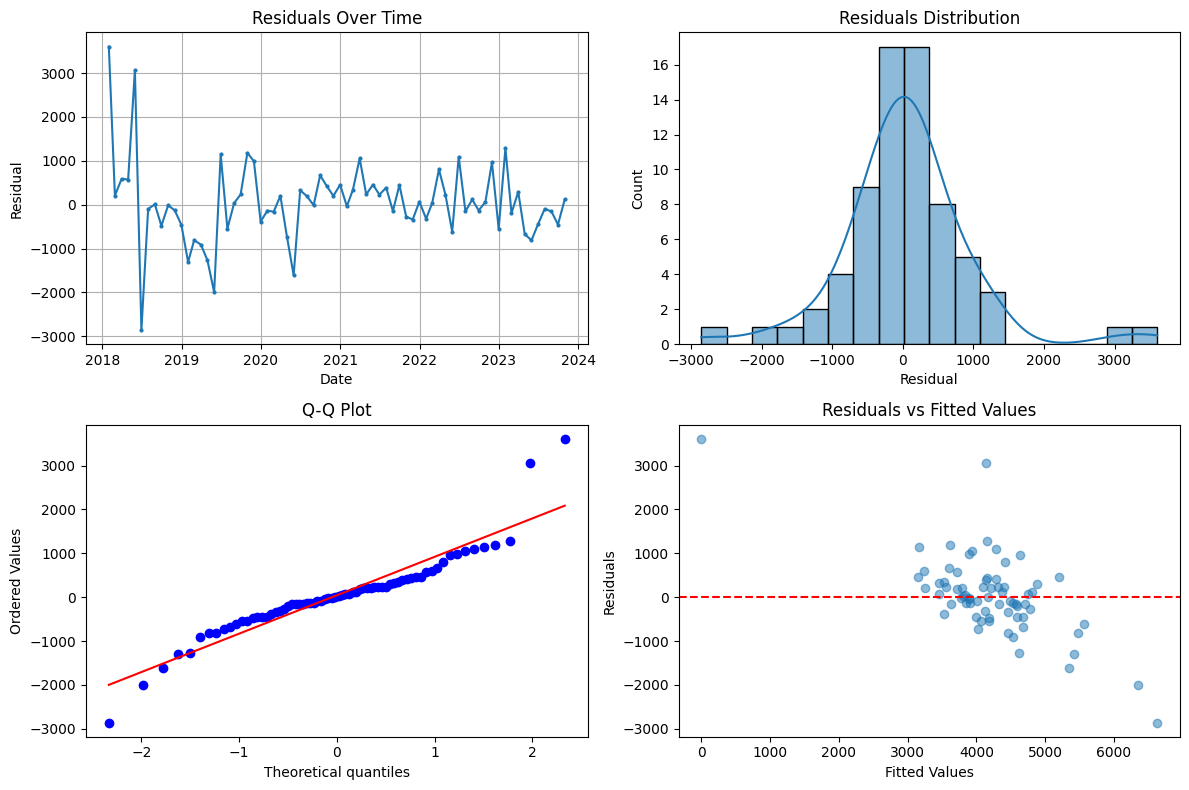


6. Generating future forecast...

7. Creating final forecast plot...


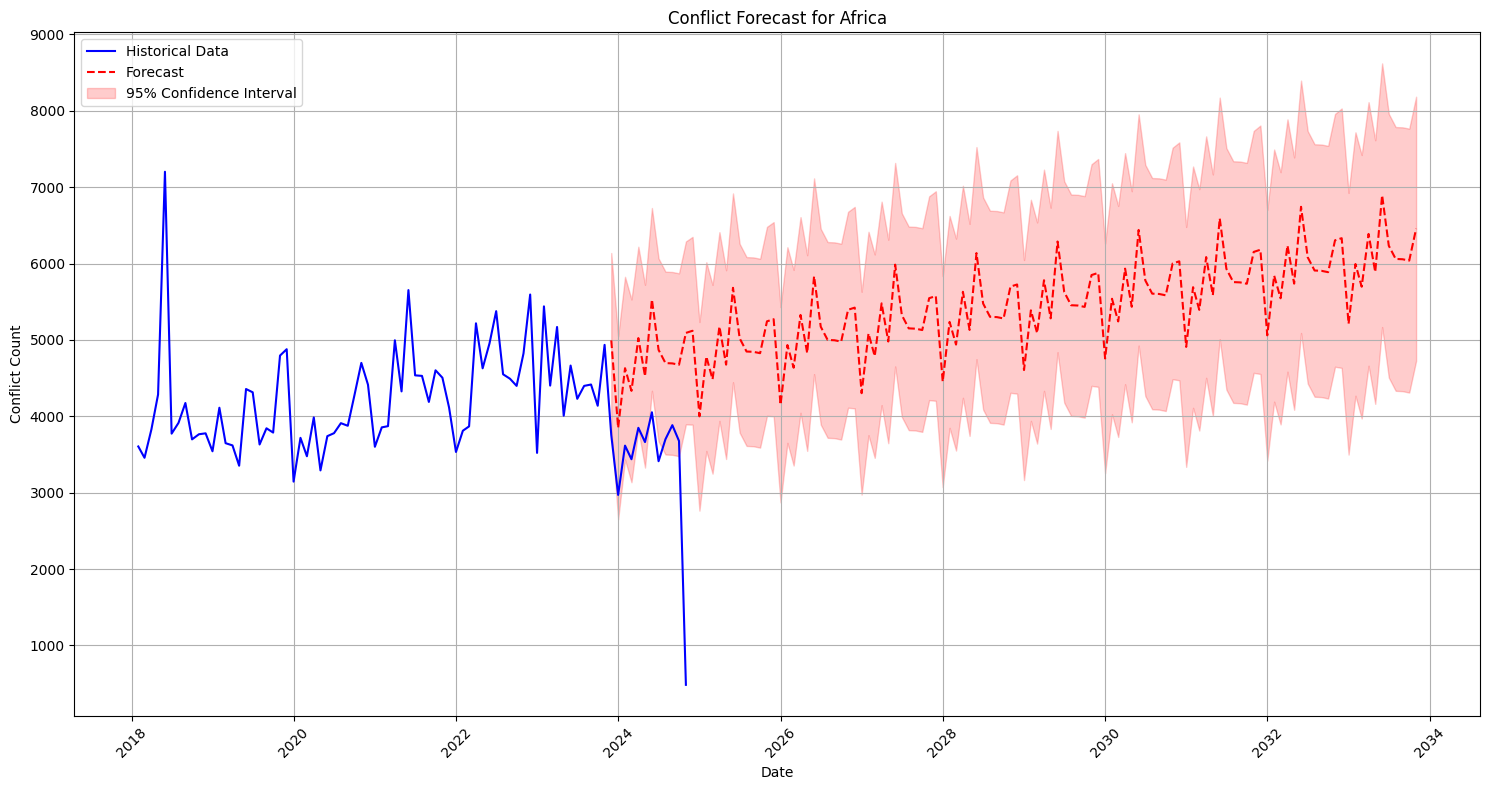

In [ ]:
# For a specific region:
model, forecast_df, plot = forecast_conflicts(agg_data, region='Africa')
plt.show()

Observation: The model appears to be severely overfitting to the training data. This is evident from the significantly worse performance on the test set compared to the training set, as indicated by the higher RMSE, MAE, and MAPE values, and the extremely low (negative) R-squared on the test set. This suggests that the model has learned the noise and specificities of the training data too well, leading to poor generalization to new, unseen data.

In [ ]:
# Display the summary of the best model
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   70
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -448.082
Date:                              Sun, 12 Jan 2025   AIC                            904.163
Time:                                      11:56:51   BIC                            912.335
Sample:                                  01-31-2018   HQIC                           907.339
                                       - 10-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7154      0.600     -1.192      0.233      -1.891       0.460
ma.L2         -0.27

Interpretation:

The SARIMAX(0, 1, 2)x(0, 1, [1], 12) model appears to be a reasonable fit for the data, based on the relatively low AIC, BIC, and HQIC values.
The coefficients for the moving average terms (ma.L1, ma.L2, and ma.S.L12) are statistically significant, indicating that they contribute meaningfully to the model.
The diagnostic tests suggest that the residuals are not autocorrelated, normally distributed, and have constant variance, which are desirable properties for a good time series model.

# General Observation and Recommendattions and Challenges.

---

The models performance on the training test was good, but not so goon on the test set, signalling overfitting. This is very much likely to affect the results of our predicted values.

Challenges faced were mostly session timeouts and crushes, requiring the need to rerun every cell block over and over again.